## Задание 1. Применение метода экспоненциального сглаживания

В данном задании вам необходимо построить модель прогнозирования для временного ряда `pigs.csv`.

<ol>
 
  <li>Реализуйте функцию экспоненциального сглаживания, которая принимает на вход три параметра: $y$, $alpha$ и $level$ и возвращает прогноз на следующую точку. Здесь
   <ul>
          <li>$y$ $-$ исходный временной ряд;</li>
          <li>$alpha$ $-$ значение параметра сглаживания $\alpha$;</li>
          <li>$level$ $-$ начальное значение уровня $l_0$.</li>
          <p></p>
      </ul>
      Получите прогноз с произвольным `alpha` и `level=y[0]`.
 </li>
 <p></p>
 
  <li>Модифицируйте функцию таким образом, чтобы она возвращала не прогноз на следующую точку, а значение среднеквадратичной ошибки:</li>
  <p></p>
  $$MSE=\frac{1}{T-1}\sum_{t=2}^{T} (y_t-\hat{y}_t)^{2}.$$
  <p></p>
<li>С помощью функции `scipy.optimize.minimize()` найдите такие параметры `alpha`, `level`, при которых MSE минимальна. Сравните полученное значение ошибки с MSE на параметрах из пункта 1.</li>

</ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import plotly.graph_objects as go
from scipy.optimize import minimize
%matplotlib inline

In [2]:
directory = '*.csv' 
files = glob.glob(directory)[1]
files

'pigs.csv'

In [3]:
df = pd.read_csv(files,index_col=0, parse_dates=True)
df.head()

,Total number of pigs slaughtered in Victoria
Month,
1980-01-01,76378
1980-02-01,71947
1980-03-01,33873
1980-04-01,96428
1980-05-01,105084


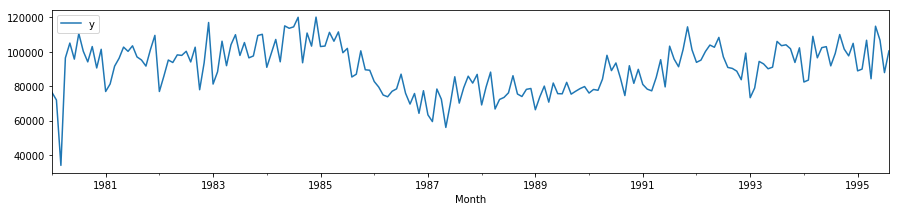

In [4]:
df.columns = ['y']
df.plot(figsize=(15, 3))

In [5]:
dt = df.drop(df.index.values[[0,1,2]])

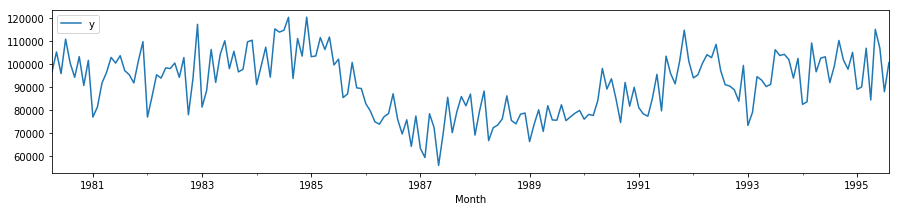

In [6]:
dt.plot(figsize=(15, 3))

In [7]:
y = dt.y.values
y

array([ 96428, 105084,  95741, 110647, 100331,  94133, 103055,  90595,
       101457,  76889,  81291,  91643,  96228, 102736, 100264, 103491,
        97027,  95240,  91680, 101259, 109564,  76892,  85773,  95210,
        93771,  98202,  97906, 100306,  94089, 102680,  77919,  93561,
       117062,  81225,  88357, 106175,  91922, 104114, 109959,  97880,
       105386,  96479,  97580, 109490, 110191,  90974,  98981, 107188,
        94177, 115097, 113696, 114532, 120110,  93607, 110925, 103312,
       120184, 103069, 103351, 111331, 106161, 111590,  99447, 101987,
        85333,  86970, 100561,  89543,  89265,  82719,  79498,  74846,
        73819,  77029,  78446,  86978,  75878,  69571,  75722,  64182,
        77357,  63292,  59380,  78332,  72381,  55971,  69750,  85472,
        70133,  79125,  85805,  81778,  86852,  69069,  79556,  88174,
        66698,  72258,  73445,  76131,  86082,  75443,  73969,  78139,
        78646,  66269,  73776,  80034,  70694,  81823,  75640,  75540,
      

## 1.1. Экспоненциальное сглаживание и предсказание

Для прогнозирования с помощью экспоненциального сглаживания применяется следующий метод:

<font size="4">
$$\hat{y}_{t+1|t} = l_t$$

$$l_t = \alpha  y_t + (1-\alpha)  l_{t-1}, \quad \alpha \in [0,1] $$
</font>
Причем в качестве начального значения $l_0$ берется первое значение ряда $y$: 
<font size="4">
$$y_0 = l_0 $$
</font>

In [8]:
def exponential(y,alpha,level):
    b = y.copy()
    for i in range(1, len(b)):
        level = b[i] = alpha*b[i]+(1-alpha)*level
    return b

Для получения значения на один месяц вперед, воспользуемся следующей формулой:

<font size="4">
$$\hat{y}_{T+1|T} = \sum_{i=0}^{T-1} \alpha \cdot (1-\alpha)^i y_{T-i} + (1-\alpha)^T \cdot l_0$$
    </font>

In [9]:
def exponential_forecast(y, alpha, level):
    forecast = sum( [alpha * (1 - alpha) ** i * x + (1-alpha) ** len(y) * level for i, x in enumerate(reversed(y))] )
    return forecast

In [10]:
alpha, level = 0.7, y[0]

dt['exp'] = exponential(y, alpha, level)

Посмотрим на то, как выглядят наши предсказания данным методом

In [11]:
xnew = dt.y.values.tolist()
xnew.append("no data")
xp = dt.exp.values.tolist()
xp.insert(0,"no forecast")
xp

fig = go.Figure(data=[go.Table(
    header=dict(values=['A Scores', 'B Scores'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[xnew,xp], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=700, height=300)
fig.show()

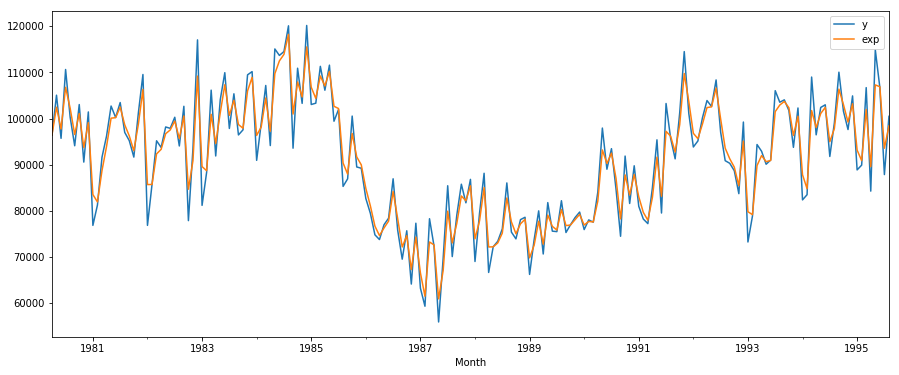

In [12]:
dt.plot(figsize=(15, 6))

## 1.2. MSE

$$SSE=\sum_{t=1}^T (y_t-\hat{y}_{t|t-1})^2=\sum_{t=1}^T e_t^2$$

Для ошибки MSE мы начинаем со второго наблюдения $y$, для этого обрезаем у $y$ первый элемент, а у списка предсказаний - последний

In [13]:
def MSE(y,y_forecast):
    return np.square(np.subtract(y,y_forecast)).mean() 

In [14]:
def exponential_mse(y,alpha,level):
    l = [level]
    for t in range(1, len(y)):
        l.append(alpha * y[t] + (1 - alpha)* l[-1])
    return MSE(y[1:], l[:-1])

In [15]:
exponential(y,alpha,level)

array([ 96428, 102487,  97764, 106782, 102266,  96573, 101110,  93749,
        99144,  83565,  81973,  88742,  93982, 100109, 100217, 102509,
        98671,  96269,  93056,  98798, 106334,  85724,  85758,  92374,
        93352,  96747,  97558,  99481,  95706, 100588,  84719,  90908,
       109215,  89622,  88736, 100943,  94628, 101268, 107351, 100721,
       103986,  98731,  97925, 106020, 108939,  96363,  98195, 104490,
        97271, 109749, 112511, 113925, 118254, 101001, 107947, 104702,
       115539, 106810, 104388, 109248, 107087, 110239, 102684, 102196,
        90391,  87996,  96791,  91717,  90000,  84903,  81119,  76728,
        74691,  76327,  77810,  84227,  78382,  72214,  74669,  67328,
        74348,  66608,  61548,  73297,  72655,  60976,  67117,  79965,
        73082,  77312,  83257,  82221,  85462,  73987,  77885,  85087,
        72214,  72245,  73085,  75217,  82822,  77656,  75075,  77219,
        78218,  69853,  72599,  77803,  72826,  79124,  76685,  75883,
      

In [16]:
exponential_forecast(y,alpha,level)

98434.07565552287

In [17]:
exponential_mse(y,alpha,level)

100982413.13129415

## 1.3. Поиск оптимальных элементов

In [18]:
res = minimize(lambda x: exponential_mse(y, x[0], x[1]), [1, y[0]])
res

      fun: 83476672.97472079
 hess_inv: array([[2.67527776e-09, 1.84153024e-05],
       [1.84153024e-05, 4.52012169e+01]])
      jac: array([-838.,    0.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 179
      nit: 10
     njev: 42
   status: 2
  success: False
        x: array([2.90544670e-01, 1.00813033e+05])

In [19]:
alpha, l0 = res.x
print('alpha: {:.6f},l0: {:.2f},MSE: {:.2f}'.format \
      (alpha,l0,res.fun))

alpha: 0.290545,l0: 100813.03,MSE: 83476672.97


In [20]:
dt['alpha {:.1f}'.format(alpha)] = exponential(y, alpha, level)

### 1.4. Проверка

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



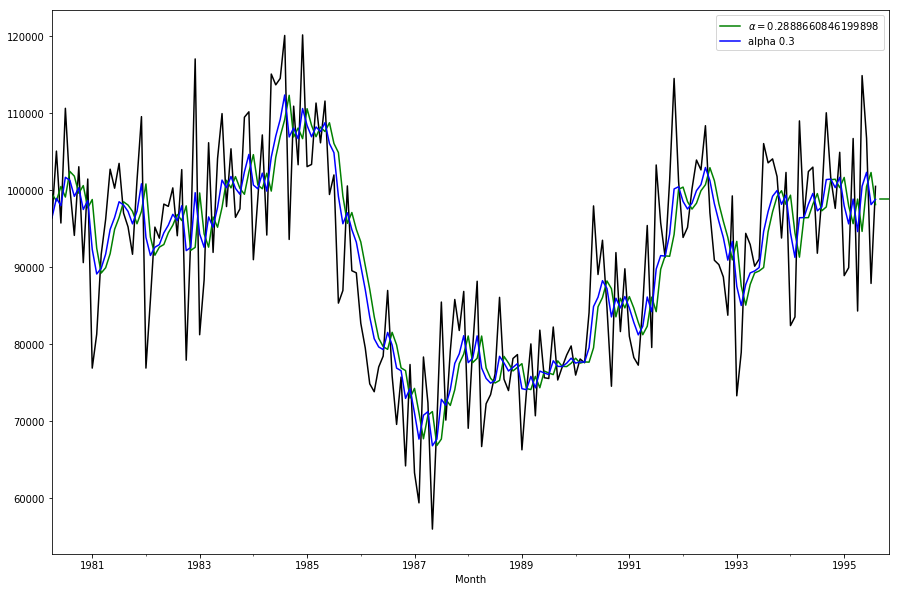

In [22]:

fit3 = SimpleExpSmoothing(dt.y).fit()
fcast3 = fit3.forecast(3).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

ax = dt.y.plot( color='black', figsize=(15,10))

fcast3.plot( ax=ax, color='green', legend=True)
fit3.fittedvalues.plot( ax=ax, color='green')

dt['alpha {:.1f}'.format(alpha)].plot( ax=ax, color='blue', legend=True)
plt.show()

Мы практически точно нашли верный результат и, если честно, не понятно, а почему результат на десятую неточен

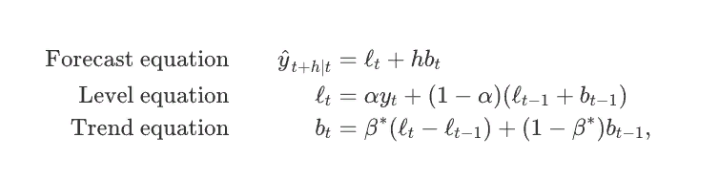

## Задание 2. Построение модели Хольта-Уинтерса

В модели Хольта-Уинтерса возможны два подхода в зависимости от характера поведения сезонной составляющей. Рассмотренный ранее  аддитивный метод применяется, когда сезонные колебания примерно постоянны по всему ряду. Аддитивный метод Хольта-Уинтерса:

<font size="4">
$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$
</font>

В случае, когда сезонные колебания изменяются пропорционально уровню ряда, говорят о мультипликативной сезонности. В данном случае мультипликативный метод Хольта-Уинтерса является более предпочтительным:

<font size="4">
$$\hat{y}_{t+h\, |\, t}=(l_t+h\, b_t)\, s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, \frac{y_t}{s_{t-m}}+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, \frac{y_t}{l_{t-1}+b_{t-1}}+(1-\gamma)\, s_{t-m}\, .$$
    </font>

При аддитивном методе сезонная компонента $s_t$ выражается в абсолютных величинах в масштабе наблюдаемого ряда, а в уравнении уровня ряд сезонно корректируется путем вычитания из него сезонной компоненты. При использовании же мультипликативного метода сезонная компонента выражается в относительных единицах, а ряд корректируется путем деления значений на сезонную компоненту.

В этом задании будем использовать данные о количестве ночей, проведенных иностранцами в гостинице Австралии `austourists.csv`.

<ol>
 
  <li>Реализуйте аддитивный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.306, \beta=0.0003, \gamma=0.426$. Оцените качество модели с помощью метрики RMSE:</li>
$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$
 <p></p>
 <li>Реализуйте мультипликативный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.441, \beta=0.03, \gamma=0.002$. Сравните качество результатов с полученными с помощью аддитивной модели.</li>

</ol>

In [23]:
directory = '*.csv' 
files = glob.glob(directory)[0]
files

'austourists.csv'

In [24]:
df_1 = pd.read_csv(files,index_col=0, parse_dates=True)

In [25]:
df_1.head()

,time,value
21,2004.00,41.273599
22,2004.25,26.655862
23,2004.50,28.279859
24,2004.75,35.191153
25,2005.00,42.205664


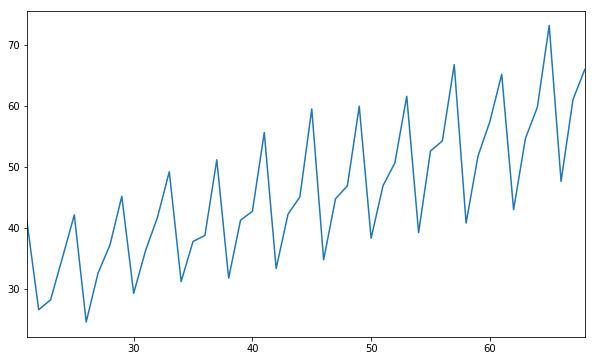

In [26]:
df_1.value.plot(figsize=(10, 6))
plt.show()

# 2.1  
Реализуйте аддитивный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.306, \beta=0.0003, \gamma=0.426$. Оцените качество модели с помощью метрики RMSE:
$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$

<font size="4">
$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+(h\bmod m )}\, ,$$
    
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$

$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$

$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$

</font>

$m$ - период сезонности

$s_i$ , $i \in 0, \ldots,s-1$ - сезонный профиль

$b_t$ - параметр тренда

$l_t$ - параметр прогноза, очищенный от влияния тренда и сезонности

In [27]:
alpha = 0.306

beta = 0.0003

gamma = 0.426

y = df_1.value.values

Тренд - изменение уровня ряда, плавное, долгосрочное

Сезонность - циклическое изменение уровня ряд  с постоянным периодом

Цикл - изменение уровня ряда с переменным периодом

Видно, что у нас период сезонности равен четырем, поэтому $m=4$

In [28]:
m = 4

Начальный параметр прогноза - `l0 = y[0]`

Начальный параметр тренда - `b0 = 0 `

Будем прогнозировать на один день, поэтому в формуле `h = 1`

Начальные значения сезонного профиля - берем первые четыре значения `y`

In [29]:
l = [y[0]]

b = [0]

h = 1

s  = y[:4]

<font size="4">
$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+(h\bmod m )}\, ,$$
    
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$

$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$

$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$

</font>

In [30]:
def add_hw(alpha,beta,gamma,y):
    m = 4
    h = 1
    l = [y[0],y[1],y[2],y[3]]
    b = [0]
    h = 1
    s = y[:m].tolist()
    arr = np.arange(m, len(y))
    y_pred = y.copy()
    prognose = 0

    for t in arr:
        lnew = alpha *( y[t] - s[t-m] ) + ( 1 - alpha ) * ( l[-1] + b[-1] )
        l.append( lnew )

        bnew = beta * ( l[-1] + l[-2] ) + ( 1 - beta ) * b[-1]
        b.append( bnew )

        snew = gamma * ( y[t] - l[-2] - b[-2] ) + ( 1 - gamma ) * s[t - m]
        s.append(snew)
        if t == len(y)-1:
            prognose = l[-1] + h * b[-1] + s[ -1 - m + (h % m)]
        else:
            y_pred[t + h] = l[-1] + h * b[-1] + s[ -1 - m + (h % m)]
    
    return y_pred,prognose

In [31]:
y_pred, prognose = add_hw(alpha,beta,gamma,y)

$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$

In [32]:
import math
def RMSE(y,y_pred):
    return math.sqrt(sum((y[4:] - y_pred[:-4])**2)/len(y)-4)

In [33]:
df_1['hw'] = y_pred

In [34]:
RMSE(y,y_pred)

5.234715680108932

In [35]:
xnew = df_1.value.values.tolist()
xnew.append("no data")
xnew.append("no data")
xnew.append("no data")
xnew.append("no data")
xp = df_1.hw.values.tolist()
xp.insert(0,"no forecast")
xp.insert(1,"no forecast")
xp.insert(2,"no forecast")
xp.insert(3,"no forecast")
xp

fig = go.Figure(data=[go.Table(
    header=dict(values=['A Scores', 'B Scores'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[xnew,xp], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=700, height=300)
fig.show()

In [36]:
prognose

75.66761385444165

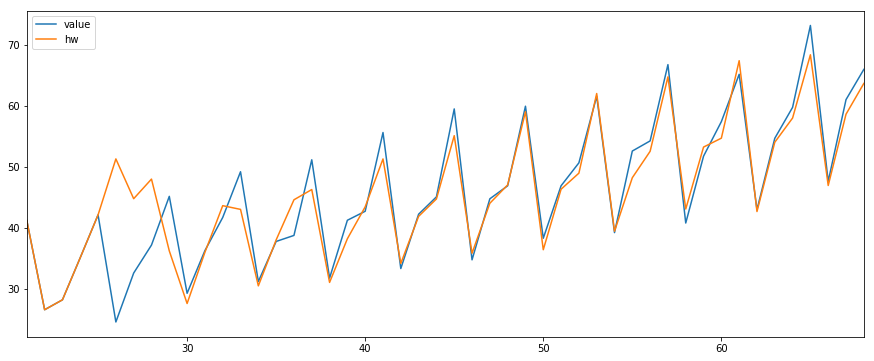

In [37]:
df_1[['value','hw']].plot(figsize=(15, 6))

# 2.2 Мультикативный

<font size="4">

$$\hat{y}_{t+h\, |\, t}=(l_t+h\, b_t)\, s_{t-m+h\bmod m }\, ,$$

$$l_t=\alpha\, \frac{y_t}{s_{t-m}}+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$

$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$

$$s_t=\gamma\, \frac{y_t}{l_{t-1}+b_{t-1}}+(1-\gamma)\, s_{t-m}\, .$$

</font>

Реализуйте мультипликативный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.441, \beta=0.03, \gamma=0.002$. Сравните качество результатов с полученными с помощью аддитивной модели

In [38]:
def mult_hw(alpha,beta,gamma,y):
    m = 4
    h = 1
    l = [y[0],y[1],y[2],y[3]]
    b = [0]
    h = 1
    s = y[:m].tolist()
    arr = np.arange( m, len(y) )
    y_pred = y.copy()
    prognose = 0

    for t in arr:
        lnew = alpha *( y[t] / s[t-m] ) + ( 1 - alpha ) * ( l[-1] + b[-1] )
        l.append( lnew )

        bnew = beta * ( l[-1] + l[-2] ) + ( 1 - beta ) * b[-1]
        b.append( bnew )

        snew = gamma * ( y[t] /( l[-2] - b[-2] )) + ( 1 - gamma ) * s[t - m]
        s.append(snew)
        if t == len(y)-1:
            prognose = (l[-1] + h * b[-1]) * s[ -1 - m + (h % m)]
        else:
            y_pred[t + h] = (l[-1] + h * b[-1]) * s[ -1 - m + (h % m)]
    
    return y_pred,prognose

In [39]:
y_pred, prognose = mult_hw(alpha,beta,gamma,y)

In [40]:
df_1['mult_hw'] = y_pred

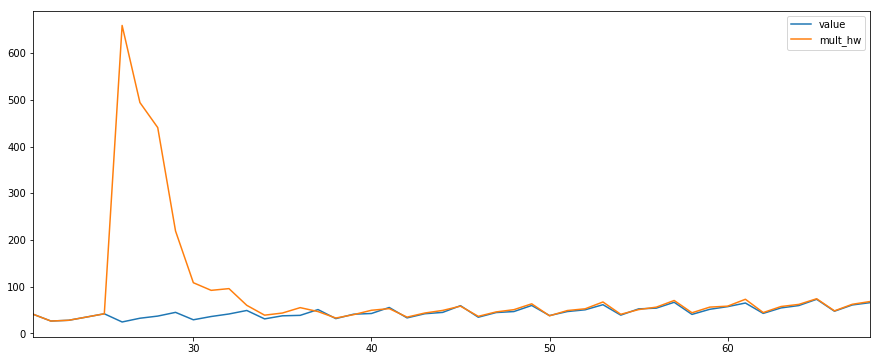

In [41]:
df_1[['value','mult_hw']].plot(figsize=(15, 6))

In [42]:
RMSE(y,y_pred)

129.79201949426482

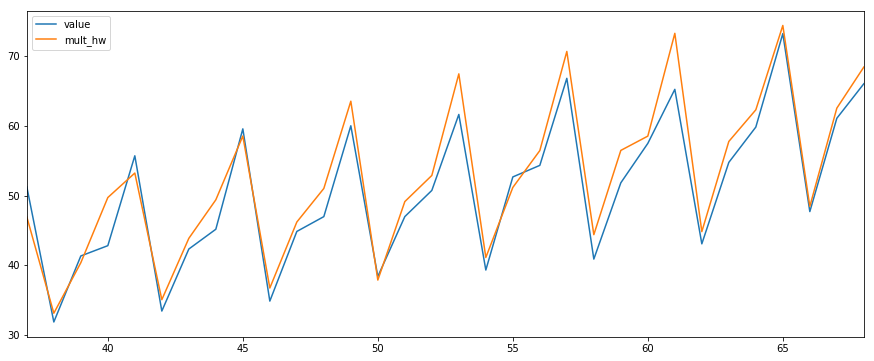

In [43]:
df_1[['value','mult_hw']][16:].plot(figsize=(15, 6))

Вывод: с аддитивной моделью лучше результат, чем с мультикативной моделью